# Practical 6: Inverse rendering

In this practical, we will solve an inverse rendering problem, where we will reconstruct the texture of a planet given a rendering. This problem is common in astronomy, where explorations programs use satellites or probes equipped with wide spectrum cameras to capture pictures from astronomical objects (Earth, other planets, asteroids). After the acquisition campaign, the raw images are processed to reconstruct various maps at the surface: albedo, clouds, elevation. 

In the first part, we will set up Pytorch3d, a differential raster renderer. We will use it first to create a virtual snapshot of the Earth and then reconstruct a part of a texture so that the rendering of a textured sphere matches the rendering of the Earth.

In the second part, we will create a new shader to support normal mapping in Pytorch3d.

In [1]:
# Change this global variable to switch between CPU/GPU usage in pytorch.
use_gpu = True

In [ ]:
# Main imports

import os
import sys
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# TODO placeholder
import warnings
class TeacherWarning(UserWarning):
    pass
def TODO(x=None):
    warnings.warn("Please fill ...", TeacherWarning)
    return x
# device selection function
def device():
    global use_gpu
    if not use_gpu:
        return torch.device('cpu')
    if not torch.cuda.is_available():
        warnings.warn("GPU required but not available. Check the execution parameters of the collab notebook", TeacherWarning)
        return torch.device('cpu')
    return torch.device('cuda')
device()

device(type='cuda')

The following code comes from pytorch3d tutorials. Because pytorch3d is not integrated into google colab, this gives a generic way to install it on many environments, depending on the version of PyTorch. 

In [ ]:
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    # We try to install PyTorch3D from source.
    !curl -LO https://github.com/NVIDIA/cub/archive/1.10.0.tar.gz
    !tar xzf 1.10.0.tar.gz
    os.environ["CUB_HOME"] = os.getcwd() + "/cub-1.10.0"
    # The following line is the correct way to install, but it takes a while on colab
    # !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
    # Here is a wheel that should install the latest version (compiled on the 10/10/2022), but much faster
    !pip install https://www-sop.inria.fr/members/Guillaume.Cordonnier/teaching/data/invrend/wheels/pytorch3d-0.7.0-cp37-cp37m-linux_x86_64.whl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  404k    0  404k    0     0   917k      0 --:--:-- --:--:-- --:--:--  917k
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.7 MB 1.5 MB/s 
     |████████████████████████████████| 42 kB 1.0 MB/s 
     |████████████████████████████████| 50 kB 7.6 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20220512-py3-none-any.whl size=61288 sha256=623ba194a85398cb7f0bb942235fee9a043e4520138f1635d70e25ca641da947
  Stored in directory: /root/.cache/pip/wheels/68/20/f9/a11a0dd63f4c13678b2a5ec488e48078756505c7777b75b29e
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31549 sha256=54781e3dc6ea8458cf63a0dd052b885459998f09285e65c9040d36e132d

Once pytorch3d is installed, we can import the main modules.

In [ ]:
import pytorch3d.io as p3d_io
import pytorch3d.vis.texture_vis as p3d_texvis
import pytorch3d.renderer as p3d_render
import pytorch3d.ops as p3d_ops

## Part 1: Texture reconstruction.

Our goal is to reconstruct the texture of earth form satelite observations. To make the practical simpler, instead of using a real footage as target, we will generate a synthetic one.
 The first step is to download the necessary data, and save them in the data/earth folder in your local colab session. Note: you can use a large subset of shell commands in collab, by prefixing them with an exclamation mark, *e.g.*, `!ls`, or `cd data`.

In [ ]:
!mkdir -p data/earth
!wget -O data/earth/earth.obj https://www-sop.inria.fr/members/Guillaume.Cordonnier/teaching/data/invrend/earth.obj
!wget -O data/earth/earth.mtl https://www-sop.inria.fr/members/Guillaume.Cordonnier/teaching/data/invrend/earth.mtl
!wget -O data/earth/albedo.jpg https://www-sop.inria.fr/members/Guillaume.Cordonnier/teaching/data/invrend/textures/albedo.jpg
!wget -O data/earth/normal.png https://www-sop.inria.fr/members/Guillaume.Cordonnier/teaching/data/invrend/textures/normal.png

--2022-10-15 16:46:52--  https://www-sop.inria.fr/members/Guillaume.Cordonnier/teaching/data/invrend/earth.obj
Resolving www-sop.inria.fr (www-sop.inria.fr)... 138.96.0.40
Connecting to www-sop.inria.fr (www-sop.inria.fr)|138.96.0.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 265975 (260K) [text/plain]
Saving to: ‘data/earth/earth.obj’

data/earth/earth.ob 100%[===================>] 259.74K   591KB/s    in 0.4s    

2022-10-15 16:46:54 (591 KB/s) - ‘data/earth/earth.obj’ saved [265975/265975]

--2022-10-15 16:46:54--  https://www-sop.inria.fr/members/Guillaume.Cordonnier/teaching/data/invrend/earth.mtl
Resolving www-sop.inria.fr (www-sop.inria.fr)... 138.96.0.40
Connecting to www-sop.inria.fr (www-sop.inria.fr)|138.96.0.40|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 217 [text/plain]
Saving to: ‘data/earth/earth.mtl’

data/earth/earth.mt 100%[===================>]     217  --.-KB/s    in 0s      

2022-10-15 16:46:55 (50.9 MB/

Then, we load the mesh.

**Q1** (1 pt): Use `p3d_io` (`pytorch3d.io` in the doc) to load `earth.obj`. Don't forget to send it to the correct device (`device()`).

In [ ]:
# Q1: Load "earth.obj" 

mesh = p3d_io.IO().load_mesh("data/earth/earth.obj", device=device())

We then use p3d_texvis to visualize the "ground truth" texture, with dots positioned at the location of the vertices on the texture.


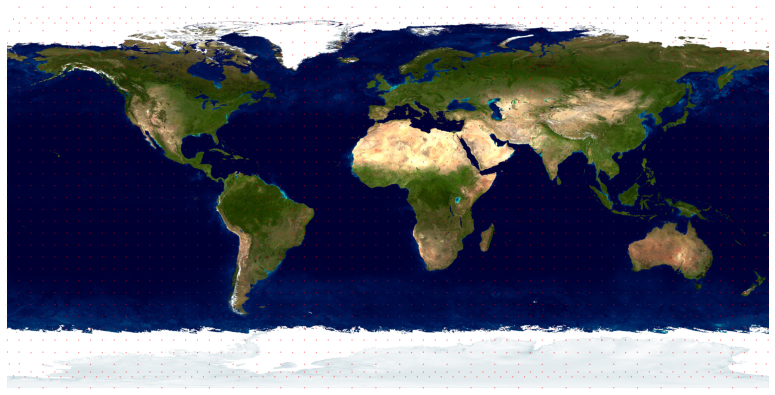

In [ ]:
plt.figure(figsize=(30,7))
p3d_texvis.texturesuv_image_matplotlib(mesh.textures, subsample=None)
plt.axis("off");

We will now create a few helper functions to set up the necessary objects prior to rendering. Let us start with the camera.

**Q2** (2 pts): Use `p3d_render.look_at_view_transform` and `p3d_render.FoVPerspectiveCameras` (see pytorch3 module `cameras`), to implement the function `create_camera`.

Note. All arguments to `FoVPerspectiveCameras` can be left with their default values except for `R` and `T`. 

In [ ]:
def create_camera(dist, elev, azim):
    """
    Input: 
     - dist: distance to the origin
     - elev: elevation angle (degrees)
     - azim: azimuth (degrees)

    Output: camera
    """

    # Q2: Implement the camera creation

    R, T = p3d_render.look_at_view_transform(dist, elev, azim, device=device())
    camera = p3d_render.FoVPerspectiveCameras(device=device(), R=R, T=T)
    return camera

We provide a function to create the renderer. 

**Q3** (2 pts) [No code required, answer in a new text cell]: Knowing that our goal is to fit a texture (no change in geometry or camera), explain why we choose a `HardPhongShader` instead of the soft variant. What do the `blur_radius` and `faces_per_pixel` parameters stand for in the rasterization parameters of a soft shader?

**Q3**, answer: 

We can use HardPhongShader for tasks where we have a fixed mesh and camera pose, and only optimize RGB values or some other vertex attributes, which is our case. But in many other cases the training wouldn't converge because the gradients flow through both shaders. 

HardPhongShader uses the differentiable rasterizer to get pix_to_face and bary_coords, then uses the phong shader to get colors for each relevant bary_coord on the mesh. Finally, it uses the hard_rgb_blend blender to "blend" the multiple faces that pix_to_face assigned to each pixel. Except, hard_rgb_blend just picks the top face and ignores the others. SoftPhongShader is the same in the first two stages, but in the last stage, it uses a blending algorithm that outputs a color that is a weighted sum of colors of all the interpolated face attributes that project to the given pixel. The blur_radius parameter makes the rasterizer pretend that each mesh face has edges that "stick out". It might assign both one point from the one side of the edge and the second point from the other side of the edge to the same pixel. On the other hand, SoftPhongShader will assign to that pixel a weighted sum of those two surfaces' colors. This means that SoftPhongShader is differentiable at boundaries. For example, if we do mesh optimization and shift the boundary just a tiny bit, then for HardPhongShader we will have a discontinuity where a pixel's color changed suddenly. But in SoftPhongShader we will not get a discontinuity.  


In [ ]:
def create_renderer(image_size, lights, cameras, shader_class = None):    
    if shader_class is None:
        shader_class = p3d_render.HardPhongShader
    return p3d_render.MeshRenderer(
        rasterizer=p3d_render.MeshRasterizer(
            cameras=cameras, 
            raster_settings=p3d_render.RasterizationSettings(
                image_size=image_size, 
                blur_radius=0.0, 
                faces_per_pixel=1)
        ),
        shader=shader_class(
            device=device(), 
            cameras=cameras,
            lights=lights,
            blend_params = p3d_render.blending.BlendParams(background_color = (0.0, 0.0, 0.0))
        ))

In [ ]:
lights = p3d_render.PointLights(device=device(), location=[[1.0, 3.0, -3.0]], ambient_color=((0.0, 0.0, 0.0), ), diffuse_color=((1.0, 1.0, 1.0), ))
renderer = create_renderer(256, lights, create_camera(2, 40, 110))

**Q4** (2 pt): Render and display the earth. To check the results: with the above parameters, the view will be centered around Center Europe. 

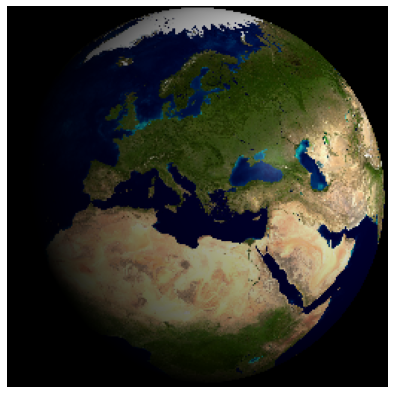

In [ ]:
# Q4: Render and display the earth with matplotlib. Name the rendered image `target`.

target = renderer(mesh)
plt.figure(figsize=(30,7))
plt.imshow(target[0, ..., :3].cpu().numpy())
plt.axis("off");

The texture map is stored in `mesh.textures.maps_padded()`, which we will process now.

In [ ]:
# disable grad to avoid errors if we re-run this cell
mesh.textures.maps_padded().requires_grad = False

# The earth texture is high resolution. To ease the optimization, we will run it on the low resolution version:
if mesh.textures.maps_padded().shape[1] == 4096:
    mesh.textures._maps_padded = mesh.textures.maps_padded()[:, ::4, ::4]

# We want to find this texture, so we start by initializing it to zero.
mesh.textures.maps_padded()[:] = 0

**Q5** (5 pts): Write the optimization loop, to fit the texture against the target image `target`.

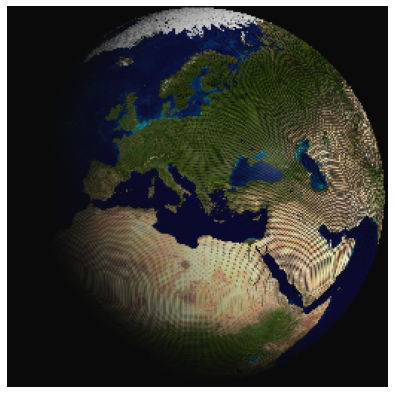

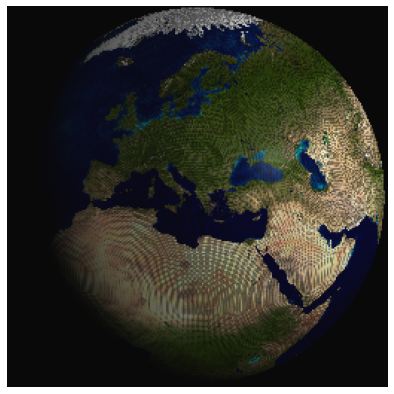

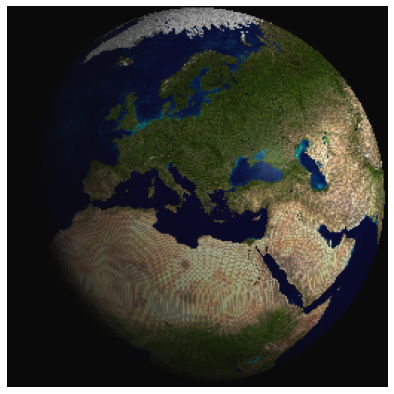

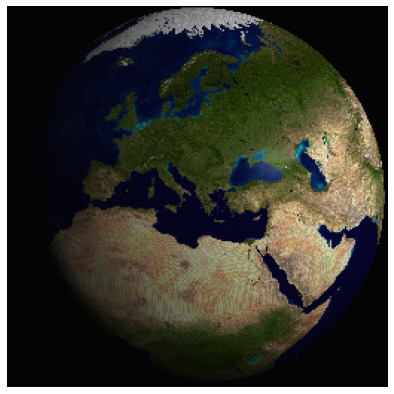

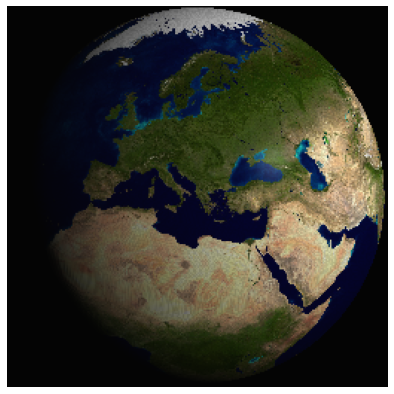

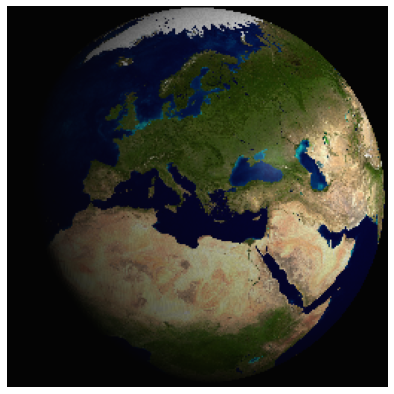

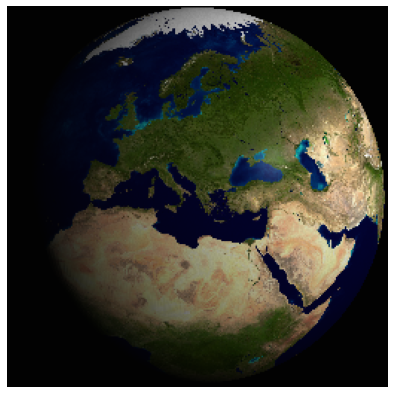

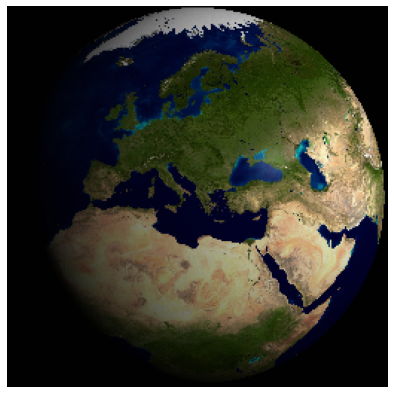

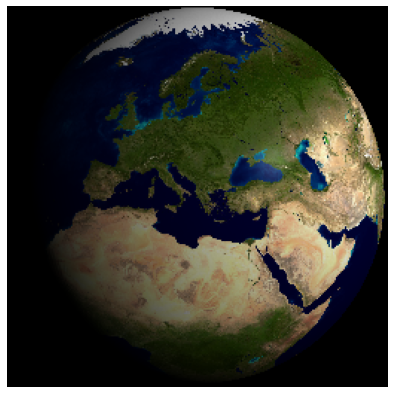

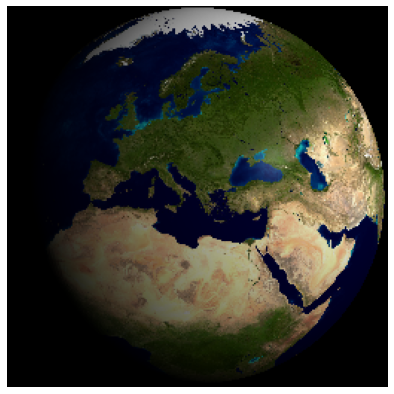

In [ ]:
# Q5: Fill the optimization loop:

from IPython import display

# 1. Activate gradient computation for the texture
mesh.textures.maps_padded().requires_grad = True

# 2. intitialize a SGD optimizer with a learning rate of 1e5, momentum 0.9
optimizer = torch.optim.SGD([mesh.textures.maps_padded()], lr=1e5, momentum=0.9)
loss_func = torch.nn.MSELoss()

losses = []

for i in range(100):
    # 3. write the  optimization steps
    optimizer.zero_grad()
    input = renderer(mesh)
    loss = loss_func(input, target)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    if i%10 == 9:
        # 4. display the intermediate renderings
        plt.figure(figsize=(30, 7))
        image = input[0, ..., :3].cpu().detach().numpy()
        image = (image - np.min(image))/np.ptp(image)
        plt.imshow(image)
        plt.axis("off");

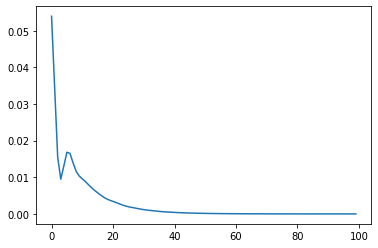

In [ ]:
plt.plot(losses)

We display the resulting texture.

**Q6** (2 pts) [No code required, answer in a new text cell]: Where do the artifacts and missing information come from? Propose an algorithm that fits a texture with no holes (on the visible part), from a single view.

**Q6,** answer: 

Artifacts and missing information has to do with how face normals are computed either by interpolating them from vertex normals or by passing them as inputs. Carefully designed models should not lead to such a discrepancy in rendering between Vert and Face shading as shapes should usually be smooth. Only when shapes are not smooth there is the difference in face normals and interpolated vertex normals that leads to these results.

Inpainting is the process of reconstructing lost or deteriorated parts of images and videos. In our case, we can use texture synthesis based image inpainting. In this method, holes are filled by sampling and copying neighboring pixels. Main difference between different texture based algorithms is how they maintain continuity between hole’s pixel and original image pixels. Yamauchi et.al presented algorithm which generate texture under different brightness condition and work for multi resolution.Bergen proposed algorithm where matching texture is synthesized from target texture.Fast synthesizing algorithm uses image quilting (stitching small patches of existing images).

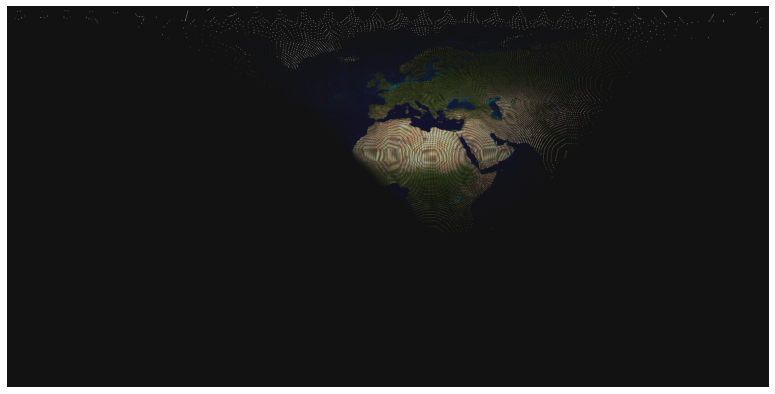

In [ ]:
plt.figure(figsize=(30,7))
image = mesh.textures.maps_padded().detach().cpu()[0].numpy()
image = (image - np.min(image))/np.ptp(image)
plt.imshow(image)
plt.axis("off");

**Bonus**: Fit the texture to match a real picture from the Earth (or another planet).

## Part 2: Custom shader for normal mapping.

We will now see how a shader is implemented in Pytorch3d, and how to extend the custom PhongShader to support normal mapping on a sphere.

First, we reload the mesh, the normal texture, and concatenate the diffuse and normal texture as a single 6D map.

In [ ]:
mesh = p3d_io.load_objs_as_meshes(["data/earth/earth.obj"], device=device())
normal = p3d_io.utils._read_image('data/earth/normal.png', path_manager=p3d_io.obj_io.PathManager(), format = "RGB")
normal = (torch.tensor(normal, device = device())/255.0)*2-1
normal[:, :, 2] = .1
normal = F.normalize(normal, p=2, dim=-1, eps=1e-6)

mesh.textures._maps_padded = torch.cat([mesh.textures.maps_padded(), normal[None]], dim = 3)


Then, we build our new shader, child `p3d_render.HardPhongShader`. To build the soft version the only difference would be to replace the call to `p3d_render.blending.hard_rgb_blend` by the soft variant, at the end of the `forward` function.

In [ ]:
import pytorch3d.renderer.mesh.shading as p3d_shading

class BumpPhongShader(p3d_render.HardPhongShader):
    def __init__(self, device = "cpu", cameras = None, lights = None, materials = None, blend_params = None):
        super().__init__(device, cameras, lights, materials, blend_params)


    def forward(self, fragments, meshes, **kwargs):
        cameras = kwargs.get("cameras", self.cameras)
        if cameras is None:
            msg = "Cameras must be specified either at initialization \
                or in the forward pass of HardPhongShader"
            raise ValueError(msg)

        texels = meshes.sample_textures(fragments)
        lights = kwargs.get("lights", self.lights)
        materials = kwargs.get("materials", self.materials)
        blend_params = kwargs.get("blend_params", self.blend_params)
        colors = bump_phong_shading(
            meshes=meshes,
            fragments=fragments,
            texels=texels,
            lights=lights,
            cameras=cameras,
            materials=materials,
        )
        images = p3d_render.blending.hard_rgb_blend(colors, fragments, blend_params)
        return images

The heart of the shader is in the `bump_phong_shading` function, which we will implement now.

The purpose of normal mapping is to distort the mesh normals on a "per-fragment" basis (look, for instance, at https://learnopengl.com/Advanced-Lighting/Normal-Mapping for more information).
One of the key elements to this normal distortion is the construction of a $(T, B, N)$ matrix, where $T$, $B$, and $N$ are the tangent, bi-tangent, and normal vectors to the shaded fragment. This matrix serves as a change of basis: The normals in the normal maps are expressed in texture space, and we want them in world space.

If $n$ is the normal in texture space, its expression in world space is the matrix-vector product:
$(T, B, N)\, n$.

In the general case; the tangent and bi-tangent vectors can be computed from the vertices positions and the texture coordinates (UV). Here, the texture mapping follows a classical Mercantor Projection, so the tangent and bitangent vectors can be computed analytically:
$$
N = (N_x,N_y,N_z) 
$$
$$
T = (N_z,0,-N_x)/ \| (N_z,0,-N_x) \|
$$
$$
B = N \times T
$$
Where $N$ is normalized and $\times$ denotes the cross product.

**Q7** (5 pts): Implement the normal mapping:

In [ ]:
def bump_phong_shading(meshes, fragments, lights, cameras, materials, texels):

    # Tensor of vertices
    verts = meshes.verts_packed()  # (V, 3)
    # tensor of faces
    faces = meshes.faces_packed()  # (F, 3)
    #tensor of vertex normals
    vertex_normals = meshes.verts_normals_packed()  # (V, 3)
    faces_verts = verts[faces]
    faces_normals = vertex_normals[faces]

    # interploate the vertex positions to obtain the coordinates of each fragment
    pixel_coords = p3d_ops.interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_verts
    )
    # interploate the vertex normals to obtain the normals of each fragment
    pixel_normals = p3d_ops.interpolate_face_attributes(
        fragments.pix_to_face, fragments.bary_coords, faces_normals
    )

    # Q7: Implement the normal mapping
    
    # 1. normalize the pixel_normals
    pixel_normals = torch.nn.functional.normalize(pixel_normals)
    
    # 2. compute the tangeant vector
    pixel_tan_x = torch.zeros((pixel_normals.shape), device=device())
    pixel_tan_x[:,:,:,:,0] = pixel_normals[:,:,:,:,2]
    pixel_tan_x[:,:,:,:,2] = -pixel_normals[:,:,:,:,0]
    norm = torch.norm(pixel_tan_x)
    pixel_tan_x = pixel_tan_x / norm

    # 3. compute the bitangeant vector
    pixel_tan_y = torch.cross(pixel_normals, pixel_tan_x, dim=4)

    # 4. transform the pixel normals
    
    #matrix =  torch.zeros((pixel_normals.shape[0], pixel_normals.shape[1], pixel_normals.shape[2], pixel_normals.shape[3], pixel_normals.shape[4], 3), device=device())
    #matrix[:,:,:,:,:,0] = pixel_tan_x
    #matrix[:,:,:,:,:,1] = pixel_tan_y 
    #matrix[:,:,:,:,:,2] = pixel_normals

    #matrix = torch.transpose(matrix, 4, 5)
  
    # I was not sure what should I use for n, therefore I did not finish this last step.
    #pixel_normals = matrix * n

    ambient, diffuse, specular = p3d_shading._apply_lighting(
        pixel_coords, pixel_normals, lights, 
        cameras, materials
    )
    # hint: you can change colors here to visualy debug the normals 
    colors = (ambient + diffuse) * texels[:, :, :, :, :3] + specular
    return colors

In [ ]:
# higher resolution renderer
lights = p3d_render.PointLights(device=device(), location=[[1.0, 3.0, -3.0]], ambient_color=((0.0, 0.0, 0.0), ), diffuse_color=((1.0, 1.0, 1.0), ))
renderer_bump = create_renderer(1024, lights, create_camera(2, 40, 110), shader_class=BumpPhongShader)

**Q8** (1 pt): Use the new high-res renderer to display the normal-mapped Earth.

(-0.5, 1023.5, 1023.5, -0.5)

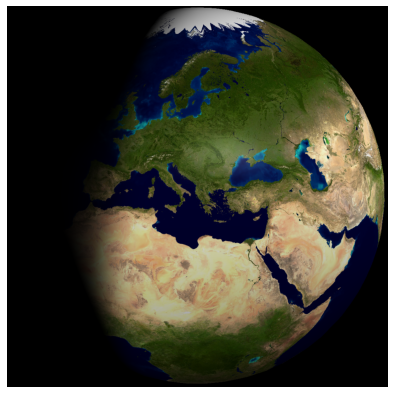

In [ ]:
# Q8: render the normal mapped earth with renderer_bump 

result = renderer_bump(mesh)
plt.figure(figsize=(30,7))
plt.imshow(result[0, ..., :3].cpu().numpy())
plt.axis("off")